<h2 style='color:blue' align='center'>Lung and Colon Cancer Histopathological Images Classification Using Convolutional Neural Network (CNN)</h2>

<img src="small_images.jpg" />

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import os

SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


<h4 style="color:purple">Load the dataset</h4>

In [3]:
import splitfolders
import os
path = r"C:\Users\Lenovo\Downloads\archive(2)\lung_colon_image_set"
print(os.listdir(path))

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [4]:
splitfolders.ratio(path,seed=1337, output="Colon-Splitted", ratio=(0.9, 0.05, 0.05))

Copying files: 25000 files [02:16, 183.50 files/s]


In [5]:
BATCH_SIZE = 25
DATA_DIRT = (r"C:\Users\Lenovo\Downloads\Colon-Splitted\train")
DATA_DIRTE = (r"C:\Users\Lenovo\Downloads\Colon-Splitted\test")
DATA_DIRV = (r"C:\Users\Lenovo\Downloads\Colon-Splitted\val")
IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
class_details = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIRT,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIRV,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    
    
)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIRTE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,

    
)


def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label


def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds=validation_ds.map(process)
testing_ds=testing_ds.map(process)


Found 22500 files belonging to 5 classes.
Found 5000 files belonging to 5 classes.
Found 3750 files belonging to 5 classes.


In [6]:
# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE



def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=30,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history

def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

## DenseNet201

In [20]:
pretrained_DenseNet201_base=tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    pooling="avg"
)
pretrained_DenseNet201_base.trainable = False


DenseNet201_modell = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.densenet.preprocess_input),
    pretrained_DenseNet201_base,
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(5, activation="softmax")
])
DenseNet201_modell.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_15 (Dense)            (None, 512)               983552    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 19570757 (74.66 MB)
Trainable params: 1248773 (4.76 MB)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________


Epoch 1/30
900/900 [==============================] - 2310s 3s/step - loss: 0.7169 - accuracy: 0.6984 - val_loss: 0.5059 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 2/30
900/900 [==============================] - 2291s 3s/step - loss: 0.5034 - accuracy: 0.7996 - val_loss: 0.4117 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 3/30
900/900 [==============================] - 2247s 2s/step - loss: 0.4469 - accuracy: 0.8182 - val_loss: 0.4104 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 4/30
900/900 [==============================] - 2252s 3s/step - loss: 0.4164 - accuracy: 0.8336 - val_loss: 0.3397 - val_accuracy: 0.8656 - lr: 0.0010
Epoch 5/30
900/900 [==============================] - 2230s 2s/step - loss: 0.3853 - accuracy: 0.8483 - val_loss: 0.3610 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 6/30
900/900 [==============================] - 34232s 38s/step - loss: 0.3598 - accuracy: 0.8549 - val_loss: 0.5644 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 7/30
900/900 [==============================] - 22

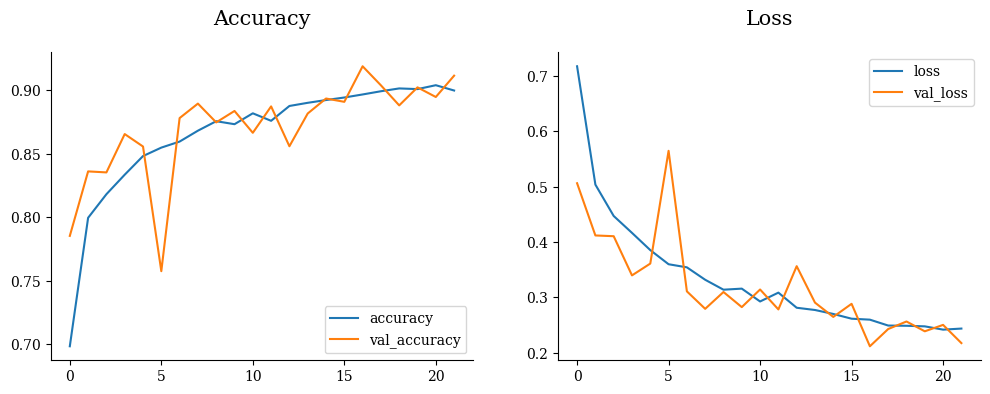

In [21]:
DenseNet201_history = compile_and_fit_model(DenseNet201_modell)

In [22]:
score =DenseNet201_modell.evaluate(testing_ds, steps = len(testing_ds)/BATCH_SIZE, verbose = 0)
print('test loss:', score[0])
print('test accuracy:', score[1])

test loss: 0.2613730728626251
test accuracy: 0.8866666555404663


## efficientnet_v2

In [8]:
pretrained_efficientnet_v2_base=tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    pooling="avg"
)
pretrained_efficientnet_v2_base.trainable = False


efficientnet_v2_modell = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input),
    pretrained_efficientnet_v2_base,
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(5, activation="softmax")
])
efficientnet_v2_modell.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-s (Function  (None, 1280)              20331360  
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 21252453 (81.07 MB)
Trainable params: 921093 (3.51 MB)
Non-trainable params: 20331360 (77.56 MB)
___________

Epoch 1/30
900/900 [==============================] - 4758s 5s/step - loss: 1.0974 - accuracy: 0.4996 - val_loss: 0.8926 - val_accuracy: 0.6144 - lr: 0.0010
Epoch 2/30
900/900 [==============================] - 4908s 5s/step - loss: 0.9530 - accuracy: 0.5866 - val_loss: 0.7911 - val_accuracy: 0.6616 - lr: 0.0010
Epoch 3/30
900/900 [==============================] - 6376s 7s/step - loss: 0.9051 - accuracy: 0.6106 - val_loss: 0.7792 - val_accuracy: 0.6588 - lr: 0.0010
Epoch 4/30
900/900 [==============================] - 6489s 7s/step - loss: 0.8727 - accuracy: 0.6244 - val_loss: 0.7318 - val_accuracy: 0.6866 - lr: 0.0010
Epoch 5/30
900/900 [==============================] - 6512s 7s/step - loss: 0.8542 - accuracy: 0.6339 - val_loss: 0.7202 - val_accuracy: 0.6794 - lr: 0.0010
Epoch 6/30
900/900 [==============================] - 4561s 5s/step - loss: 0.8229 - accuracy: 0.6500 - val_loss: 0.7045 - val_accuracy: 0.6872 - lr: 0.0010
Epoch 7/30
900/900 [==============================] - 3014

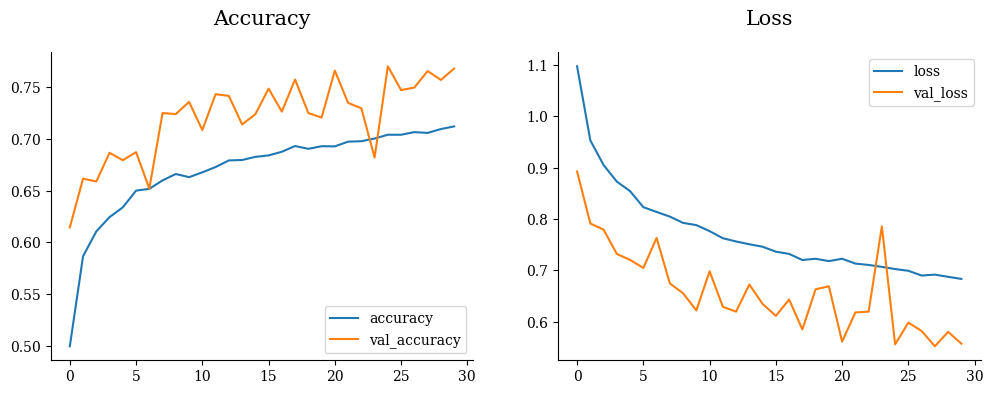

In [10]:
efficientnet_v2_history = compile_and_fit_model(efficientnet_v2_modell)

In [11]:
score =efficientnet_v2_modell.evaluate(testing_ds, steps = len(testing_ds)/BATCH_SIZE, verbose = 0)
print('test loss:', score[0])
print('test accuracy:', score[1])

test loss: 0.555532693862915
test accuracy: 0.7599999904632568
